In [48]:
from cpymad.madx import Madx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.optimize import least_squares as ls
from scipy.optimize import minimize as som

from scipy.optimize import fmin_cobyla
from scipy.optimize import shgo

# standard configurations
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display


def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

In [49]:
# constraint for cobyla here
def con1(x):
    return 0.05-np.sum(x**2)


def input_str(x):
    return '''
    
    CALL, FILE = "Optics_v7.str";
    CALL, FILE = "CRYRING_v7.1.0.seq";

    beam, particle = proton, sequence=cryring, pc = {};
    use, sequence=cryring;

    select, flag=twiss, column=apertype, aper_1, aper_2;
    twiss;
    '''.format(x)


# ! extend to dx/dkd !!
# replace with scalar function
def find_gradient_x(theta):

#    print(theta)
#    print(np.sum(theta**2))
    
    kf0=0.5086546699
    kd0 =-0.6511149282
    delta = kf0/100

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
    twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="hmonitor"]["x"]
#    xbpm0 =aux[aux["keyword"]=="quadrupole"]["x"]
#    xbpm0 =aux["x"]

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
    twiss;'''.format(kf0+delta,kd0+delta,*theta)); # check here

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]
#    xbpm =aux[aux["keyword"]=="quadrupole"]["x"]
#    xbpm =aux["x"]

    vecf = np.array(xbpm-xbpm0)/delta
#    vecf = np.array(xbpm-xbpm0)

#---------------
#    madx.input('''kqfl ={}; kqdl ={}; 
#    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};kkhec1={},kkhec2={};
#    twiss;'''.format(kf0-delta,kd0+delta,*theta)); # check here

#    aux=madx.table.twiss.dframe()
#    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]
#    xbpm =aux[aux["keyword"]=="quadrupole"]["x"]
#    xbpm =aux["x"]

#    vecd = np.array(xbpm-xbpm0)/delta

#---------------

#    print(np.linalg.norm(vecf))
#    return vec

    return np.linalg.norm(vecf)
#    return np.linalg.norm(vecf)**2 + np.linalg.norm(vecd)**2
#    return np.sum(vec) # extention to k_d will be easier




def find_gradient_y(theta):
    
#    print(np.sum(theta**2))
    
    kf0=0.5086546699
    kd0 =-0.6511149282    
    delta = kf0/100

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};
    twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    ybpm0 =aux[aux["keyword"]=="vmonitor"]["y"]

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};
    twiss;'''.format(kf0+delta,kd0+delta,*theta));

    aux=madx.table.twiss.dframe()
    ybpm = aux[aux["keyword"]=="vmonitor"]["y"]
    
    vec = np.array(ybpm-ybpm0)/delta

    return np.linalg.norm(vec)

def trun_norm(cut):
    x = np.random.normal()
    return x+cut if np.abs(x)<cut else trun_norm(cut)
    

In [50]:
madx = Madx(stdout=False)

pc = np.sqrt(2*0.9382720813*50*10**(-6)) # Kin Energy 50 KeV
myStr0 = input_str(pc)

# check the seed, it can be the cause of the error


dxdy = [trun_norm(2.5) for i in range(2*3*6)]


myStr1 = '''
addquaderr(dx_err,dy_err,quadname): macro = {
SELECT, FLAG=error, clear;
eoption, add=false;
SELECT, FLAG=error, PATTERN="quadname";

EALIGN, DX:=0.005*(dx_err-2.5), DY:=0.005*(dy_err -2.5); 
};'''


myStr2 = '''

exec, addquaderr({},{},YR02QS1);
exec, addquaderr({},{},YR02QS2);
exec, addquaderr({},{},YR02QS3);

exec, addquaderr({},{},YR04QS1);
exec, addquaderr({},{},YR04QS2);
exec, addquaderr({},{},YR04QS3);

exec, addquaderr({},{},YR06QS1);
exec, addquaderr({},{},YR06QS2);
exec, addquaderr({},{},YR06QS3);

exec, addquaderr({},{},YR08QS1);
exec, addquaderr({},{},YR08QS2);
exec, addquaderr({},{},YR08QS3);

exec, addquaderr({},{},YR10QS1);
exec, addquaderr({},{},YR10QS2);
exec, addquaderr({},{},YR10QS3);

exec, addquaderr({},{},YR12QS1);
exec, addquaderr({},{},YR12QS2);
exec, addquaderr({},{},YR12QS3);

SELECT, FLAG = ERROR, FULL;
ESAVE, FILE = err.txt;

select,flag=interpolate, class=drift, slice=20, range=#s/#e;
!select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
select,flag=interpolate, class=sbend, slice=10, range=#s/#e;
twiss;
'''.format(*dxdy)


madx.input(myStr0);
madx.input(myStr1);
madx.input(myStr2);
DF0=madx.table.twiss.dframe()
bpmDF0 = DF0[DF0["keyword"]=="hmonitor"]
qsPos = DF0[DF0["keyword"]=="quadrupole"]

err =madx.table.efield.dframe()
qsERR = err[err["name"].str.contains("qs")]


In [51]:
theta_x = np.random.normal(0,0.00001,8)
theta_y = np.random.normal(0,0.00001,6)
#theta_x = np.zeros(8)
#theta_y = np.zeros(6)

vec_xg = fmin_cobyla(find_gradient_x, theta_x, cons=[con1], rhobeg=.001, rhoend=0.00005)
vec_yg = fmin_cobyla(find_gradient_y, theta_y, cons=[con1], rhobeg=.001, rhoend=0.001)

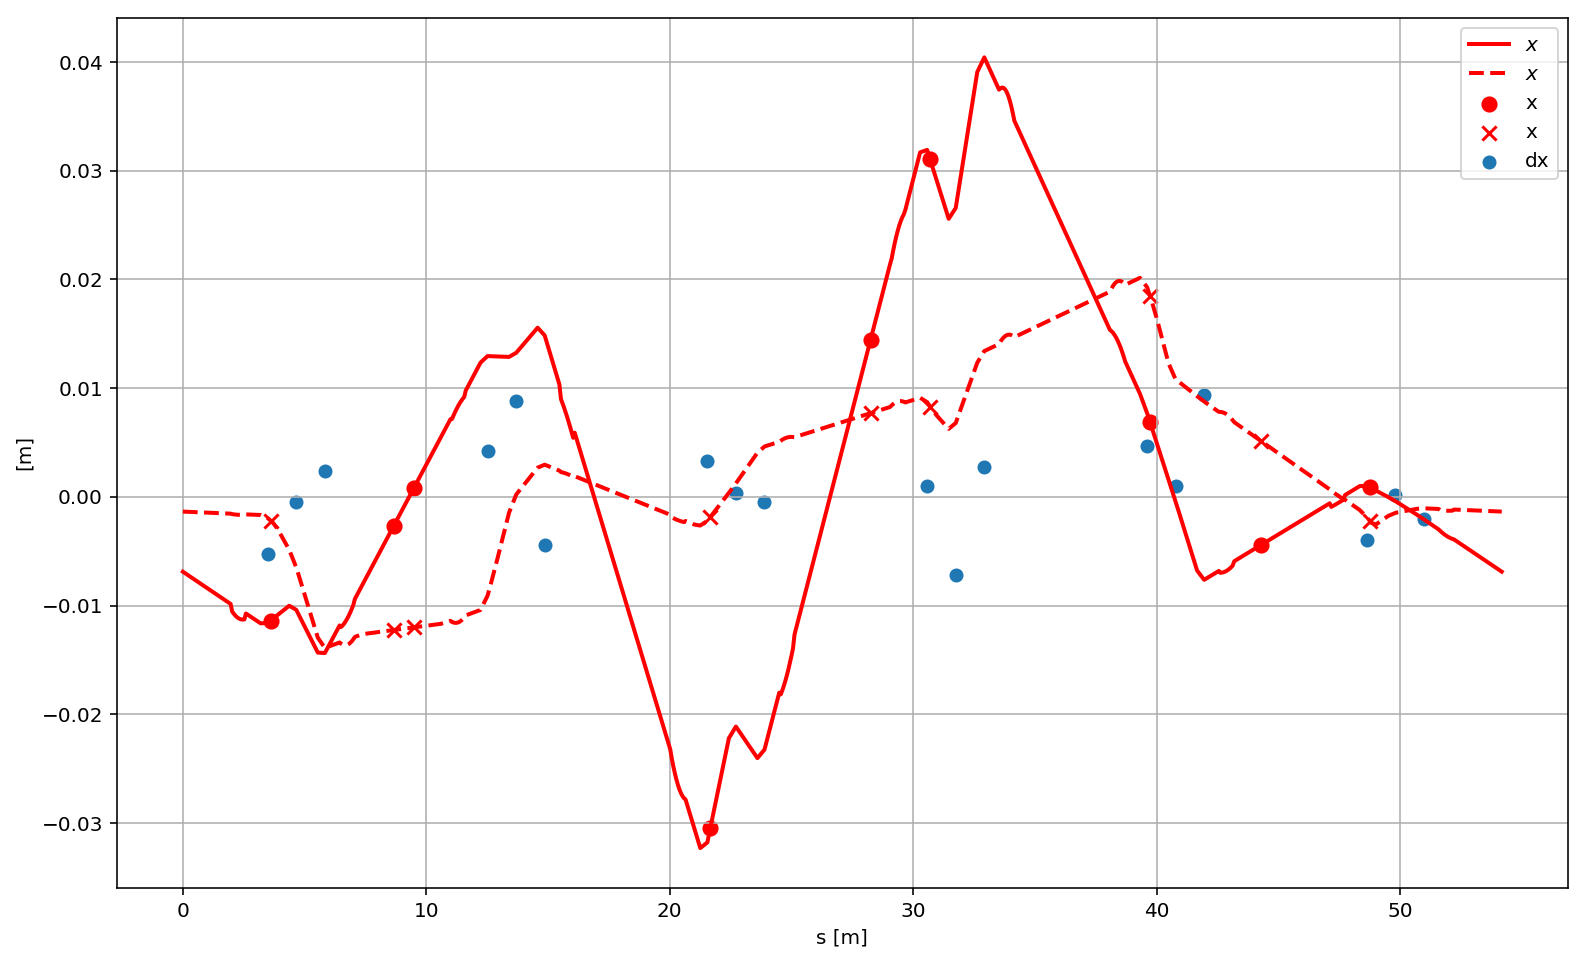

In [52]:
madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_xg));

madx.input('''k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};twiss;'''.format(*vec_yg))

DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]

fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='$x$', lw=2)
#plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50)
#plt.scatter(bpmDF0.s,bpmDF0.y, color = "blue", s = 50)

plt.plot(DF['s'],DF['x'],'r',ls="--", label='$x$', lw=2)
#plt.plot(DF['s'],DF['y'],'b',ls="--", label='$y$', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50, marker="x")
#plt.scatter(bpmDF.s,bpmDF.y, color = "blue", s = 50, marker="x")

plt.scatter(qsPos.s,qsERR.dx)

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()


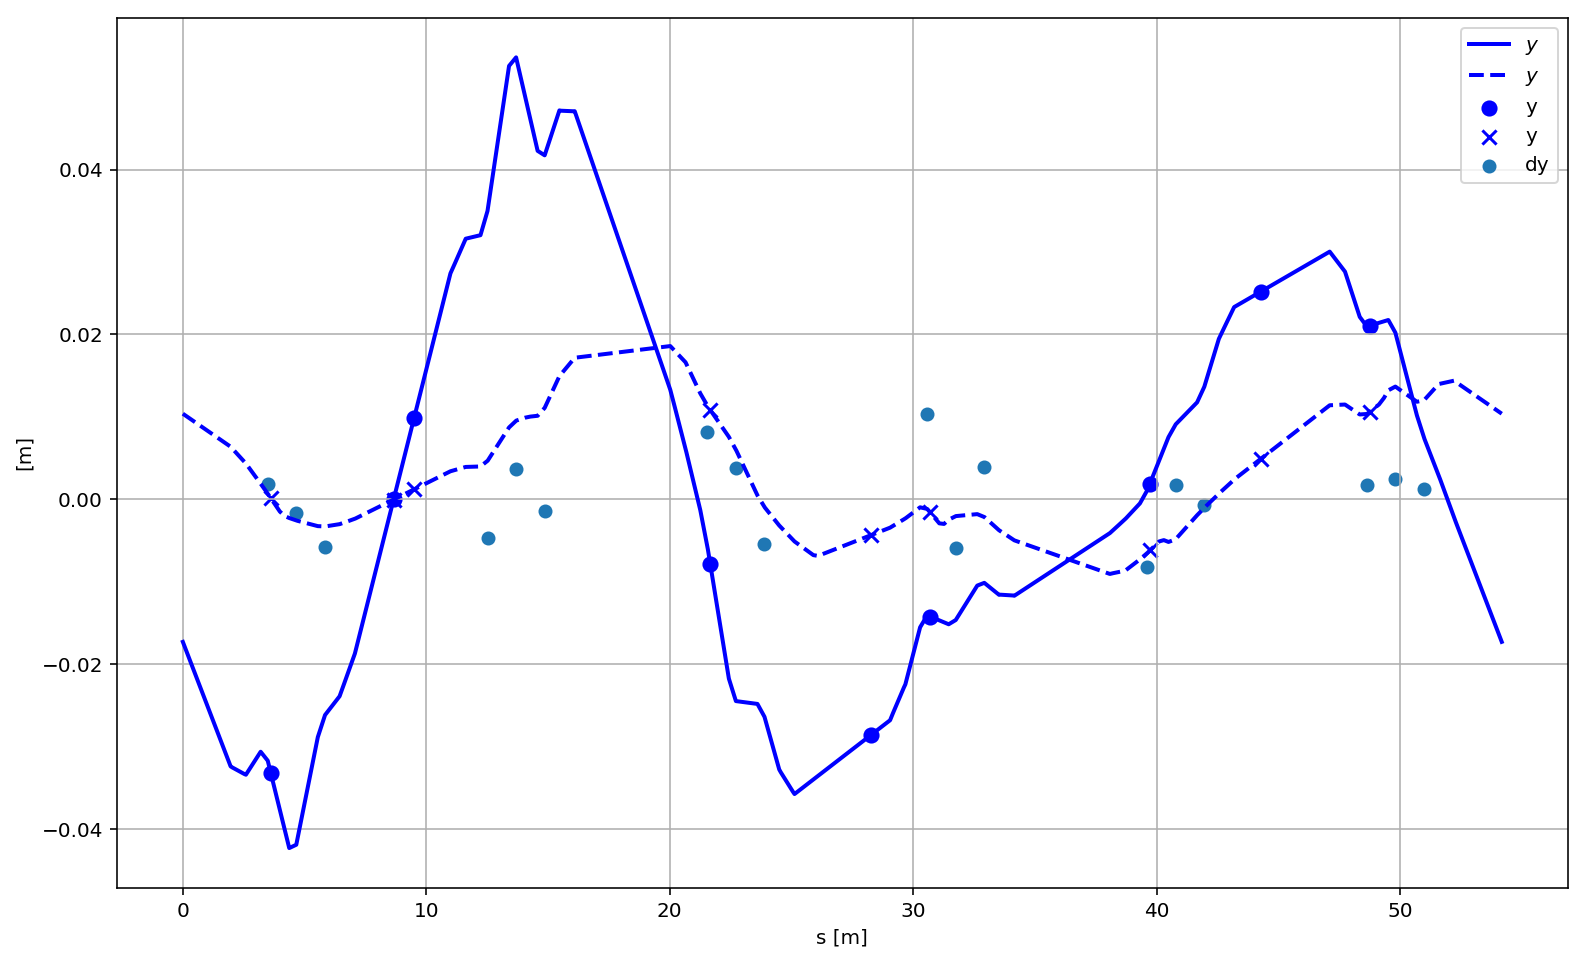

In [53]:
fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.y, color = "blue", s = 50)

plt.plot(DF['s'],DF['y'],'b',ls="--", label='$y$', lw=2)
plt.scatter(bpmDF.s,bpmDF.y, color = "blue", s = 50, marker="x")

plt.scatter(qsPos.s,qsERR.dy)

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

In [54]:
def find_orb_x(theta):
      
    madx.input('''k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};twiss;'''.format(*theta));
    
    aux=madx.table.twiss.dframe()
#    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]
    xbpm =aux[aux["keyword"]=="quadrupole"]["x"]
    
    vec = np.array(np.array(xbpm)-np.array(qsERR["dx"]))
#    vec = np.array(xbpm)

    return np.linalg.norm(vec)



def find_orb_y(theta):
      
    madx.input('''k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};twiss;'''.format(*theta));

    aux=madx.table.twiss.dframe()
#    ybpm = aux[aux["keyword"]=="vmonitor"]["y"]
    ybpm =aux[aux["keyword"]=="quadrupole"]["y"]

    vec = np.array(np.array(ybpm)-np.array(qsERR["dy"]))
#    vec = np.array(ybpm)

    return np.linalg.norm(vec)

In [55]:
theta_x = np.random.normal(0,0.00001,8)
theta_y = np.random.normal(0,0.00001,6)
#theta_x = np.zeros(8)
#theta_y = np.zeros(6)

vec_xo = fmin_cobyla(find_orb_x, theta_x, cons=[con1], rhobeg=.0005, rhoend=0.00001)
vec_yo = fmin_cobyla(find_orb_y, theta_y, cons=[con1], rhobeg=.0005, rhoend=0.00001)

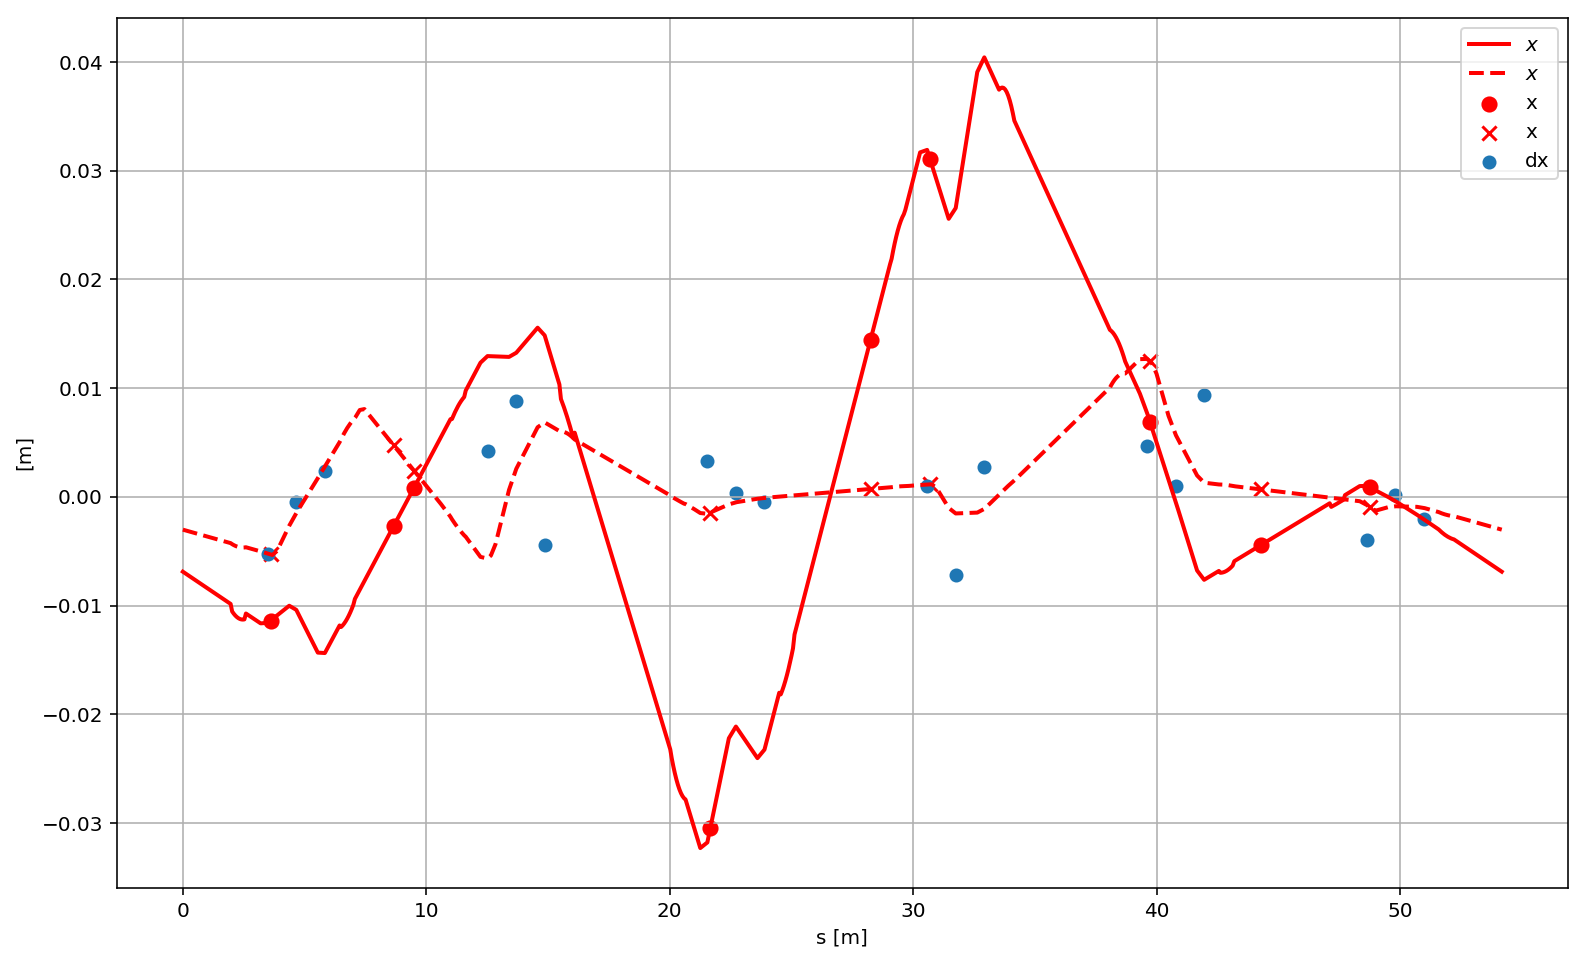

In [56]:
madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_xo));

madx.input('''k02kv = {};k04kv = {};k07kv = {};k08kv ={};k10kv ={};k12kv ={};twiss;'''.format(*vec_yo))

DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]

fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='$x$', lw=2)
#plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50)
#plt.scatter(bpmDF0.s,bpmDF0.y, color = "blue", s = 50)

plt.plot(DF['s'],DF['x'],'r',ls="--", label='$x$', lw=2)
#plt.plot(DF['s'],DF['y'],'b',ls="--", label='$y$', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50, marker="x")
#plt.scatter(bpmDF.s,bpmDF.y, color = "blue", s = 50, marker="x")

plt.scatter(qsPos.s,qsERR.dx)

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

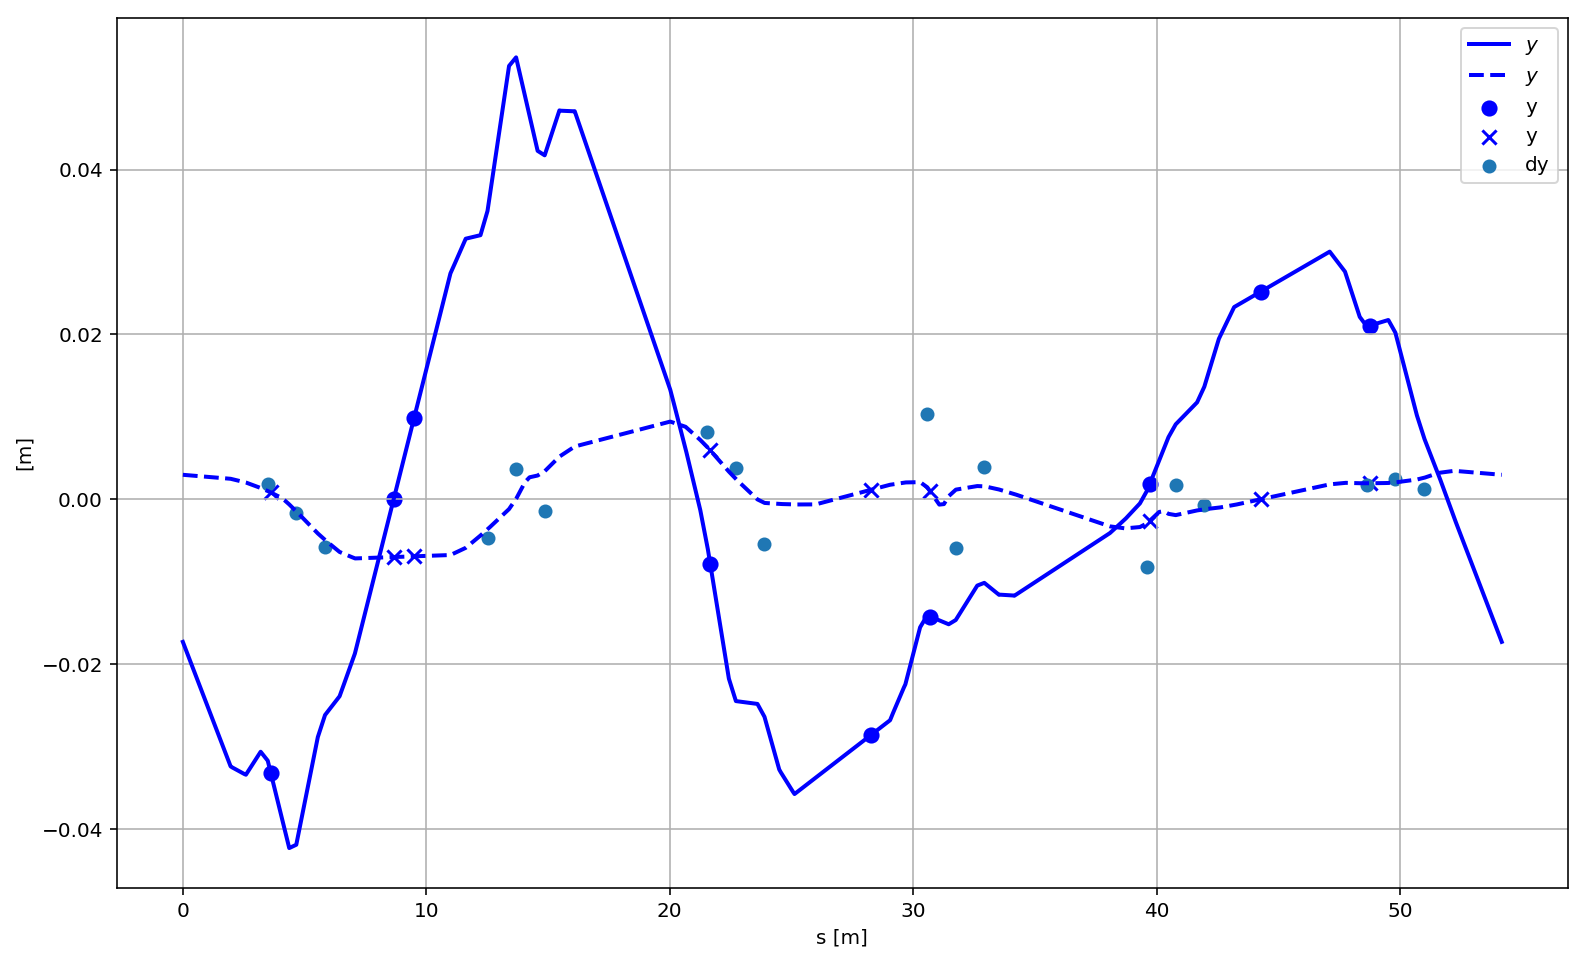

In [57]:
fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.y, color = "blue", s = 50)

plt.plot(DF['s'],DF['y'],'b',ls="--", label='$y$', lw=2)
plt.scatter(bpmDF.s,bpmDF.y, color = "blue", s = 50, marker="x")

plt.scatter(qsPos.s,qsERR.dy)

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

In [58]:
gx0 = find_gradient_x(vec_xg)
gx1 = find_gradient_x(vec_xo)

dx1 = find_orb_x(vec_xg)
dx2 = find_orb_x(vec_xo)

print("\t\tgrad_find \t zero orb at quads")
print(f"gradient is {gx0} {gx1}")
print(f"offset at quads {dx1} {dx2}")

		grad_find 	 zero orb at quads
gradient is 0.11067437173566622 0.021457798949506664
offset at quads 0.03651027265480493 0.022535514584742868


In [59]:
gy0 = find_gradient_y(vec_yg)
gy1 = find_gradient_y(vec_yo)

print(f"{gy0} {gy1}")

0.24435956219009383 0.018590457301590747


In [60]:
th = np.linalg.norm(vec_xo)/100

N=20
aux = []


tmp1 =[]
for k in range(8):
    theta = list(vec_xo)[:]
    theta[k]-=N/2*th

    aux = []
    for i in range(N):
        theta[k]+=th
#        aux.append(find_gradient_x(theta))
        aux.append([theta[k],find_gradient_x(theta)])

    tmp1.append(np.transpose(aux))

    

#aux = []
#for i in range(N):
#    theta[0]+=th
#    aux.append(find_orb_x(theta))


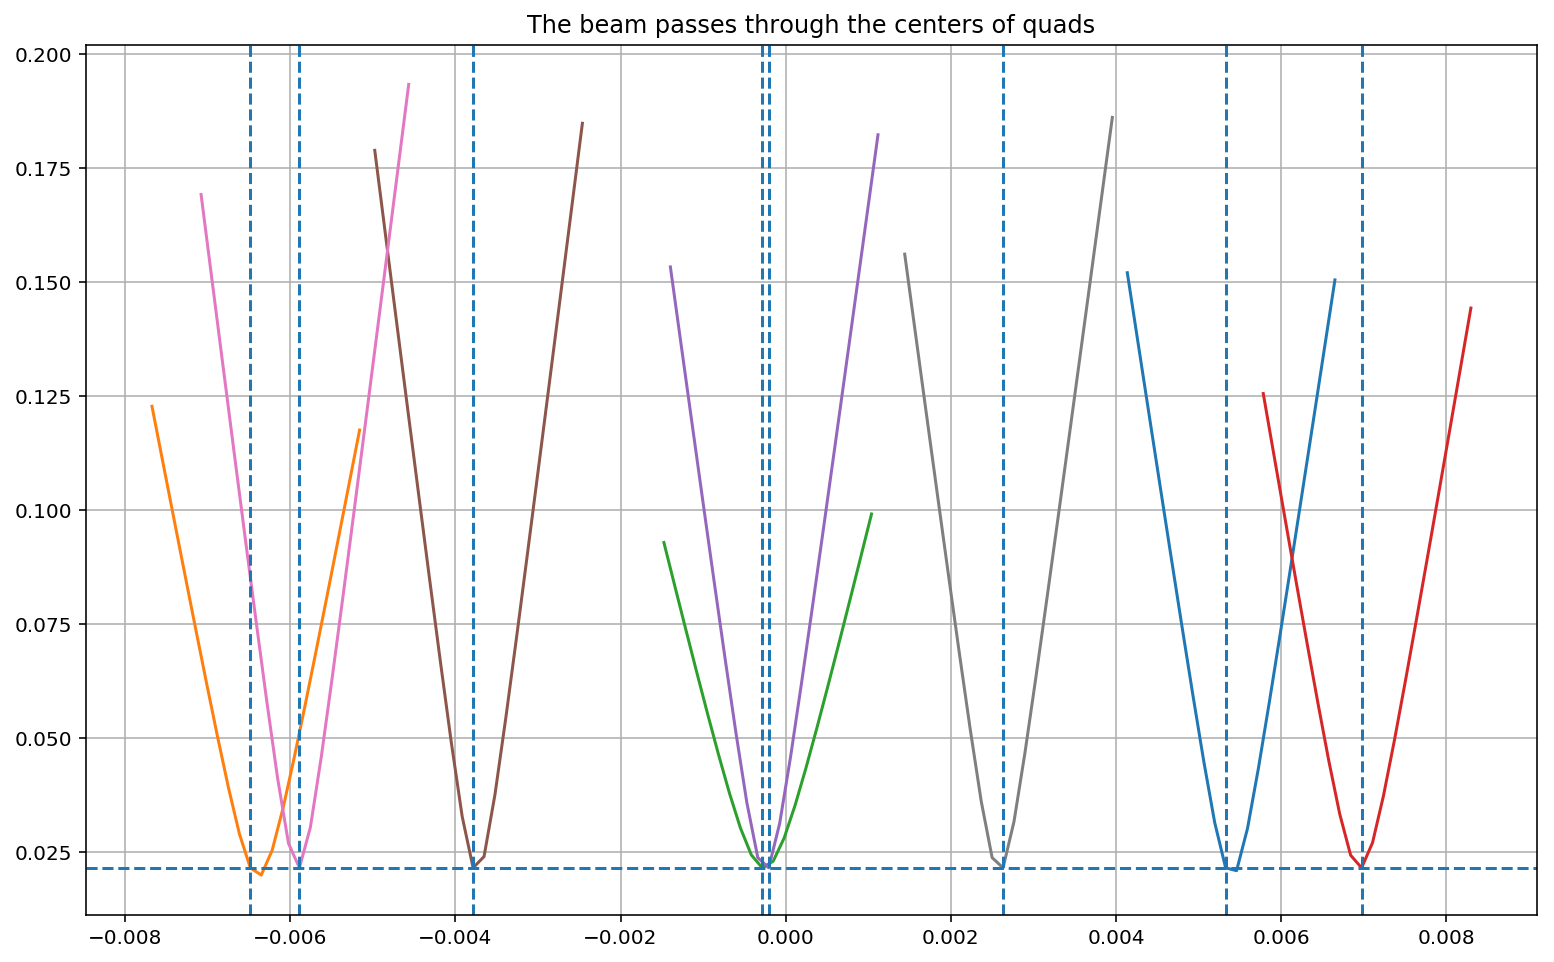

In [61]:
fig = plt.figure(figsize=(13,8))

#plt.plot(np.linspace(-N/2,N/2,N),np.transpose(tmp))
[plt.plot(tmp1[i][0],tmp1[i][1]) for i in range(8)]
[plt.axvline(x, ls ="--") for x in vec_xo]
plt.axhline(gx1, ls="--")
plt.title("The beam passes through the centers of quads")
#plt.plot(np.linspace(-N/2,N/2,N),aux)
#plt.plot(np.linspace(-N/2,N/2,N),tmp[-2])
plt.grid(True)
plt.show()

In [62]:
th = np.linalg.norm(vec_xg)/100

aux = []


tmp2 =[]
for k in range(8):
    theta = list(vec_xg)[:]
    theta[k]-=N/2*th

    aux = []
    for i in range(N):
        theta[k]+=th
#        aux.append(find_orb_x(theta))
        aux.append([theta[k],find_gradient_x(theta)])
    tmp2.append(np.transpose(aux))


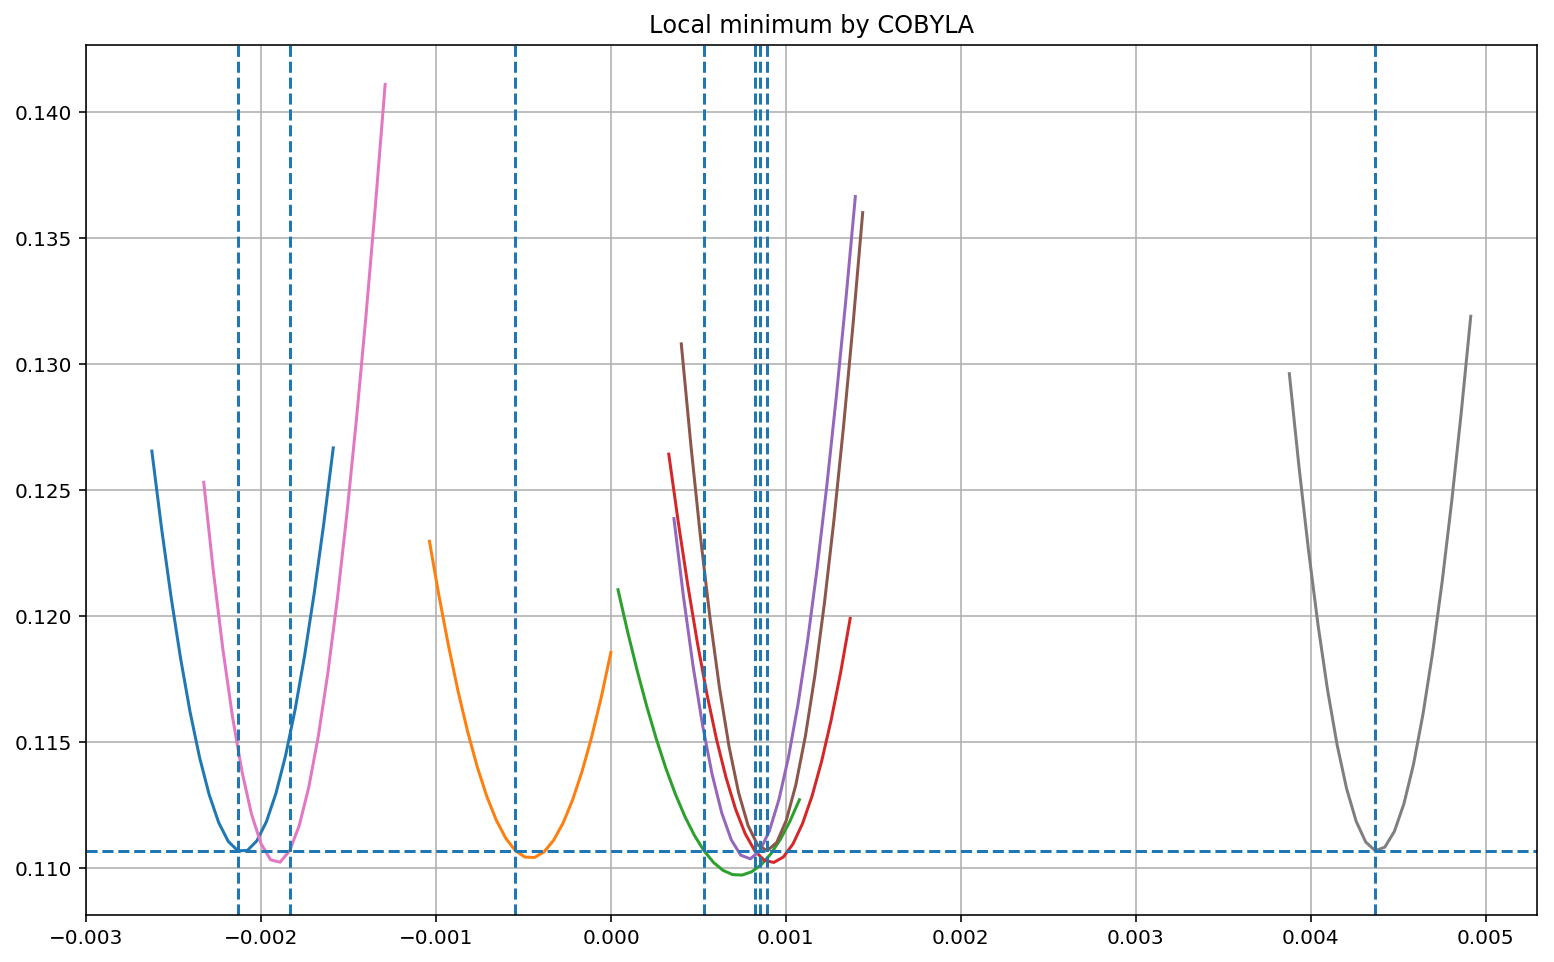

In [63]:
fig = plt.figure(figsize=(13,8))

#plt.plot(np.linspace(-N/2,N/2,N),np.transpose(tmp))
[plt.plot(tmp2[i][0],tmp2[i][1]) for i in range(8)]
[plt.axvline(x, ls ="--") for x in vec_xg]
plt.axhline(gx0, ls="--")
plt.title("Local minimum by COBYLA")
#plt.plot(np.linspace(-N/2,N/2,N),aux)
#plt.plot(np.linspace(-N/2,N/2,N),tmp[-2])
plt.grid(True)
plt.show()

In [77]:
theta_x = np.random.normal(0,0.001,8)
theta_y = np.random.normal(0,0.001,6)
#theta_x = np.zeros(8)
#theta_y = np.zeros(6)

#bnd_x = [(-0.001,0.001) for x in theta_x]

def con2(t):
    return 0.05 - np.max(np.abs(t))

#vec_xg = shgo(find_gradient_x, bounds=bnd_x, options= {"f_min":gx1})
vec_xg1 = fmin_cobyla(find_gradient_x, theta_x, cons=[con1], rhobeg=.0012, rhoend=0.00005)

gx2 =find_gradient_x(vec_xg1)
print(f"{gx0} {gx2} goal {gx1}")

0.11067437173566622 0.0934796628721622 goal 0.021457798949506664


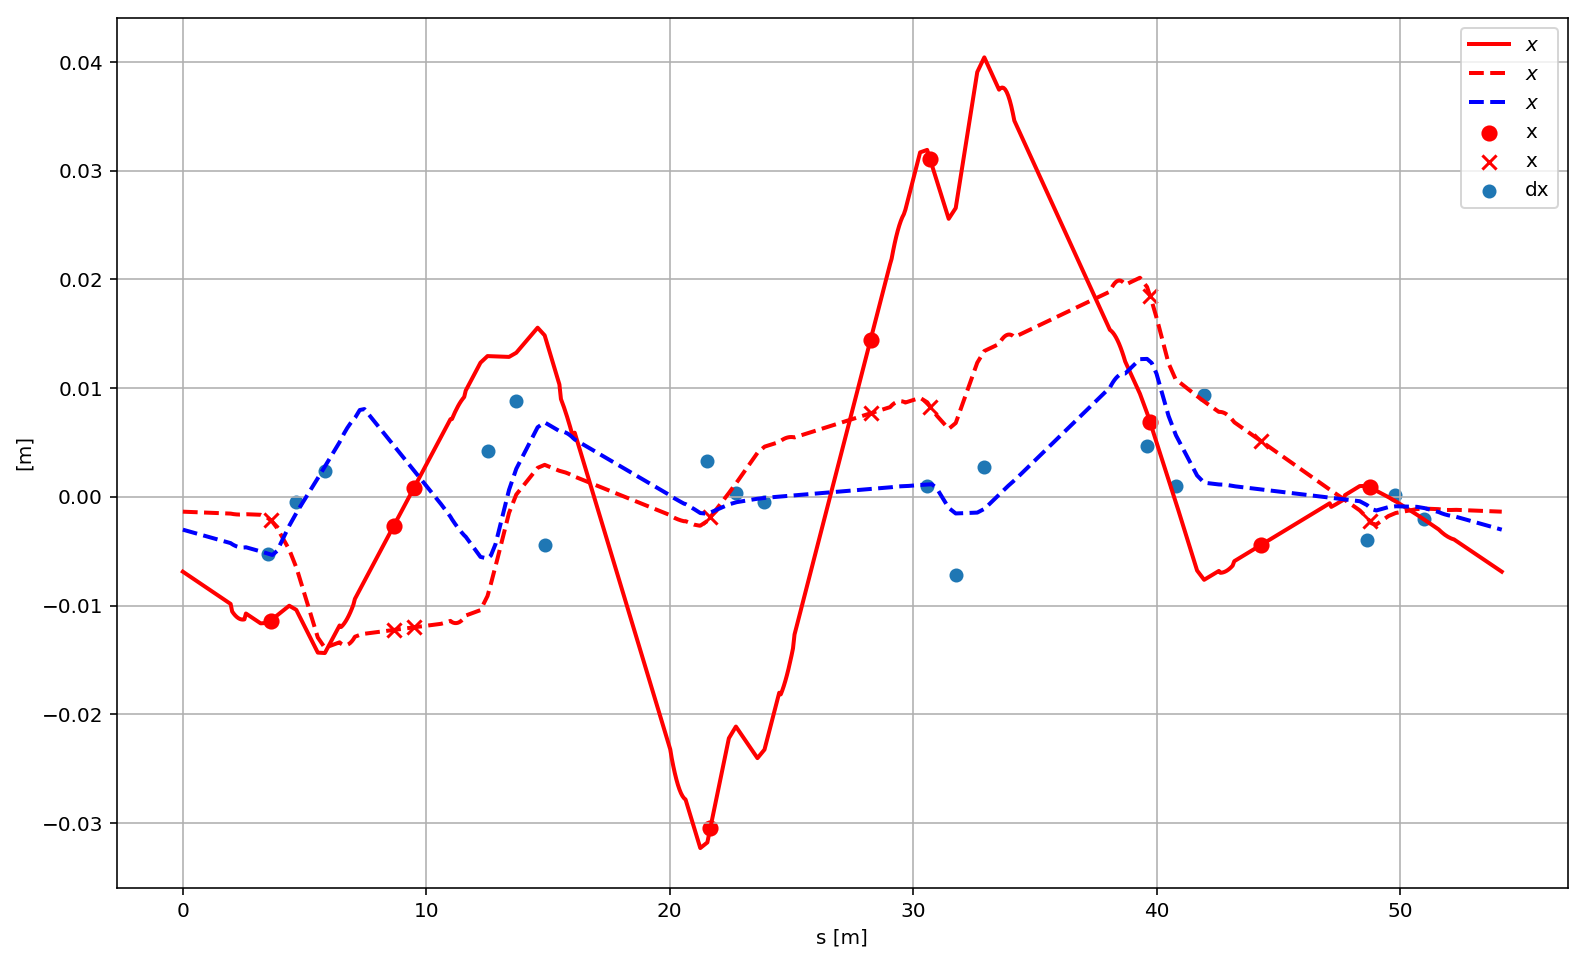

In [79]:
madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_xg));


DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]

madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};
twiss;'''.format(*vec_xo));

DF1=madx.table.twiss.dframe()
#bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]


fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='$x$', lw=2)
#plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50)
#plt.scatter(bpmDF0.s,bpmDF0.y, color = "blue", s = 50)

plt.plot(DF['s'],DF['x'],'r',ls="--", label='$x$', lw=2)
#plt.plot(DF['s'],DF['y'],'b',ls="--", label='$y$', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50, marker="x")
#plt.scatter(bpmDF.s,bpmDF.y, color = "blue", s = 50, marker="x")

plt.plot(DF1['s'],DF1['x'],'blue',ls="--", label='$x$', lw=2)

plt.scatter(qsPos.s,qsERR.dx)

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

In [69]:
# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# instatiate the optimizer
x_max = 0.001 * np.ones(8)
x_min = -1 * x_max
bounds = (x_min, x_max)

#options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} #Global
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k': 2, 'p': 2}
optimizer = ps.single.LocalBestPSO(n_particles=30, options=options, dimensions=8, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(find_gradient_x, 1000)

2019-07-18 17:40:04,576 - pyswarms.single.local_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|██████████|1000/1000, best_cost=0.976
2019-07-18 17:43:01,256 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.9759586747417242, best pos: [-6.07511289e-04  5.13753062e-04  3.18607255e-04  7.93742420e-04
 -8.09446159e-04 -6.71782453e-04  4.73467318e-05  8.56905950e-04]


In [81]:
find_gradient_x(pos)

0.9759586747417242